In [65]:
#%load_ext autoreload
#%autoreload 2

In [66]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import os
import scipy.io
import neuronumba
import scipy.integrate as integrate
from scipy.linalg import expm
from scipy.linalg import solve_continuous_lyapunov
from DataLoaders.baseDataLoader import DataLoader
import ADNI_A
from functions_FDT_numba_v8 import *
from functions_boxplots_WN3_v0 import *
from functions_violinplots_WN3_v0 import *
import filterps
from functions_violinplots_WN3_v0 import plot_violins_HC_MCI_AD
from typing import Union


In [67]:
# Loading the data and data loader

DL = ADNI_A.ADNI_A()

# example of individual
sc = DL.get_subjectData('002_s_0413')
SC = sc['002_s_0413']['SC']
time = sc['002_s_0413']['timeseries']
print(sc['002_s_0413'].keys())
#print(SC)

# Loading the data for all subjects
HC_IDs = DL.get_groupSubjects('HC')
HC_MRI = {}
for subject in HC_IDs:
    data = DL.get_subjectData(subject)
    HC_MRI[subject] = data[subject]['timeseries'].transpose()

MCI_IDs = DL.get_groupSubjects('MCI')
MCI_MRI = {}
for subject in MCI_IDs:
    data = DL.get_subjectData(subject)
    MCI_MRI[subject] = data[subject]['timeseries'].transpose()

AD_IDs = DL.get_groupSubjects('AD')
AD_MRI = {}
for subject in AD_IDs:
    data = DL.get_subjectData(subject)
    AD_MRI[subject] = data[subject]['timeseries'].transpose()

# Okay this is loading in the effecetive connectivity, so we cannot use this for f_diff
# we need to use the data loader to get the timeseries data
EC_HC_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/HC_FDT_results_filters0109.mat')
EC_MCI_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/MCI_FDT_results_filters0109.mat')
EC_AD_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/AD_FDT_results_filters0109.mat')
print(EC_HC_data.keys()) # check the keys

print(AD_MRI['011_S_4547'].shape)


dict_keys(['timeseries', 'ABeta', 'Tau', 'SC'])
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
dict_keys(['__header__', '__version__', '__globals__', 'Ceff_subjects', 'FDTm_subjects', 'fittCVtau_subjects', 'fittFC_subjects', 'perCeff_subjects', 'perFC_subjects', 'perFDT_subjects'])
(197, 379)


### Load empirical data

In [68]:
#data_folder = 'Data_W_N3'

#data = scipy.io.loadmat(f'{data_folder}/DataSleepW_N3.mat')
#SC = np.array(data['SC'])

#NPARCELLS = len(SC)

NPARCELLS = 379

In [69]:
def calc_H_freq(
        all_HC_fMRI: Union[np.ndarray, dict], 
        tr: float, 
        version: filterps.FiltPowSpetraVersion=filterps.FiltPowSpetraVersion.v2021
    ):
        """
        Compute H freq for each node. 
        
        Parameters
        ----------
        all_HC_fMRI: The fMRI of the "health control" group. Can be given in a dictionaray format, 
                     or in an array format (subject, time, node).
                     NOTE: that the signals must already be filitered. 
        tr: TR in milliseconds
        version: Version of FiltPowSpectra to use

        Returns
        -------
        The h frequencies for each node
        """
        f_diff = filterps.filt_pow_spetra_multiple_subjects(all_HC_fMRI, tr, version)
        return 2 * np.pi * f_diff  # omega

In [70]:
### LOAD DATA from files for the Brain-state Hopf

### Set condition
COND = 5 # 1: W, 2: N3, 3: HC, 4: MCI, 5: AD


# Load MATLAB file: mat
if COND == 1: ## --> W
    ### Ceff
    data = scipy.io.loadmat(f'{data_folder}/Ceff_FC_DSET_1_COND_{COND}_NSUB_15_DFILT_0_FREQSUB_0.mat')
    Ceffgroup = np.array(data['Ceffgroup'])
    Ceffsub = np.array(data['Ceffsub'])
    ### Freqs.
    data = scipy.io.loadmat(f'{data_folder}/hopf_freq_AAL90_COND_{COND}_W.mat')
    f_diff = np.array(data['f_diff'])
    f_diff_sub = np.array(data['f_diff_sub'])
    del data
    ### Noise
    # sigma = 0.12  # Old autocorrelation
    sigma = 0.1     # IT
elif COND == 2: ## --> N3
    ### Ceff
    data = scipy.io.loadmat(f'{data_folder}/Ceff_FC_DSET_1_COND_{COND}_NSUB_15_DFILT_0_FREQSUB_0.mat')
    Ceffgroup = np.array(data['Ceffgroup'])
    Ceffsub = np.array(data['Ceffsub'])
    ### Freqs.
    data = scipy.io.loadmat(f'{data_folder}/hopf_freq_AAL90_COND_{COND}_N3.mat')
    f_diff = np.array(data['f_diff'])
    f_diff_sub = np.array(data['f_diff_sub'])
    del data
    ### Noise
    # sigma = 0.06  # Old autocorrelation
    sigma = 0.08    # IT

elif COND == 3: ## --> HC
    ### Ceff
    Ceffgroup = EC_HC_data['Ceff_subjects']
    f_diff = calc_H_freq(HC_MRI, 3000, filterps.FiltPowSpetraVersion.v2021)
    
    ### Noise
    # sigma = 0.06  # Old autocorrelation
    sigma = 0.08    # IT

elif COND == 4: ## --> MCI
    ### Ceff
    Ceffgroup = EC_MCI_data['Ceff_subjects']
    f_diff = calc_H_freq(MCI_MRI, 3000, filterps.FiltPowSpetraVersion.v2021)
    
    ### Noise
    # sigma = 0.06  # Old autocorrelation
    sigma = 0.08    # IT

elif COND == 5: ## --> AD
    ### Ceff
    Ceffgroup = EC_AD_data['Ceff_subjects']
    f_diff = calc_H_freq(AD_MRI, 3000, filterps.FiltPowSpetraVersion.v2021)
    
    ### Noise
    # sigma = 0.06  # Old autocorrelation
    sigma = 0.08    # IT
print(f_diff.shape)

(379,)


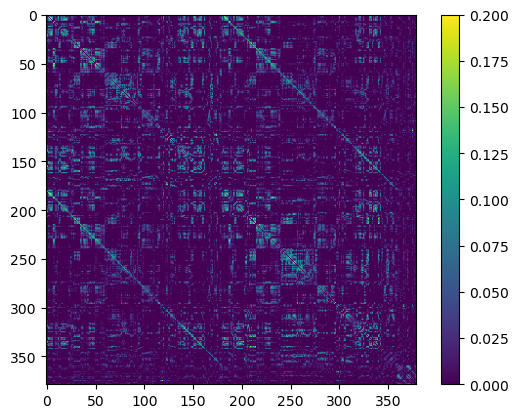

In [71]:
### CONNCETIVITY

## Use structural conectivity
STRUCTURAL = 0

# take the healthy EC
Ceffgroup = EC_HC_data['Ceff_subjects']

Connectivity = Ceffgroup[0]
norm = np.max(Connectivity)
Ceff = Connectivity[:NPARCELLS,:NPARCELLS]
if STRUCTURAL == 1:
    Ceff = SC[:NPARCELLS,:NPARCELLS]

### Plot connectivity
plt.imshow(Ceff)
plt.colorbar()
plt.show()


In [72]:
### We define the variables for the HOPF MODEL ########################
## Bifurcation parameter (same for all parcells) [Hopf only]
aparam = -0.02
avec = aparam * np.ones(NPARCELLS) # Possibility for different a values

## Nodes frequencies [Hopf only]
#freqs = f_diff[0,:NPARCELLS]
#omega = 2*np.pi*freqs

omega = f_diff[:NPARCELLS]
print(omega)

## Coupling constant [Hopf only]
gconst = 1.0

## Repetition time [Hopf only]
TR = 2
#######################################################################

### Set sigma #########################################################
sigma = 0.08
sigma = sigma * np.ones(NPARCELLS)
## Set homogeous (=0) or heterogeneous (=1) values of sigma for the nodes
HETEROGENEOUS = 0

## Set same sigma for all conditions
SAMESIGMA = 0

if HETEROGENEOUS == 1:
    SAMESIGMA = 0
    data = scipy.io.loadmat(f'{data_folder}/sigma_sub_DSET_1_COND_{COND}_NSUB_15_DFILT_0_FREQSUB_1_NITER_100_NSUBSIM_10_IT_INTERPOLATE_1.mat')
    sigma = np.array(data['sigmagroup'])[0,:]
    del data
    if COND == 2:
        sigma[54] = np.mean(sigma)
        sigma[35] = np.mean(sigma)
if SAMESIGMA == 1:
    HETEROGENEOUS = 0
    sigma = 0.05 * np.ones(NPARCELLS)
#######################################################################

### Select Model: #####################################################
## LINHOPF == 1 --> Linear Hopf
## LINHOPF == 0 --> Langevin Langevin
LINHOPF = 1

## Linear Hopf
if LINHOPF == 1:
    Gamma = -construct_matrix_A(avec, omega, Ceff, gconst)
    Ndim = 2 * NPARCELLS
    sigma = np.append(sigma, sigma)
## Linear Langevin
else:
    # I made this so that the diagonal elements are Cii > sum_j Cij
    row_sums = np.sum(Ceff, axis=1)
    non_diag_sums = row_sums - np.diag(Ceff)
    np.fill_diagonal(Ceff, non_diag_sums+0.05)
    Gamma = Ceff
    Ndim = NPARCELLS
#######################################################################

### Initial conditions: ###############################################
## Random initial condition (v0 = v0bias + v0std*np.random.standard_normal)
v0std = sigma
v0bias = 0.0
# v0bias = np.random.rand(Ndim)
## THERMALIZATION: if == 1, performs THERMALIZATION
THERMALIZATION = 1
#######################################################################


[0.25728102 0.242397   0.26791247 0.25090215 0.17860831 0.21369209
 0.27216505 0.22857612 0.32000656 0.3327643  0.29023851 0.37635323
 0.27641763 0.26259675 0.31575398 0.26047046 0.34977461 0.3115014
 0.33914317 0.19774492 0.27854392 0.22219725 0.2019975  0.42206845
 0.26897561 0.42632103 0.28067021 0.27748077 0.2923648  0.34871147
 0.25940731 0.3923004  0.32000656 0.29449109 0.30831197 0.2615336
 0.34871147 0.23176555 0.27854392 0.32744857 0.42206845 0.29661738
 0.26897561 0.31575398 0.28704907 0.34977461 0.29449109 0.22326039
 0.28173335 0.24346014 0.3519009  0.29768052 0.28811222 0.27960706
 0.24664958 0.29980681 0.30724882 0.35934292 0.30512254 0.323196
 0.42738418 0.4231316  0.22007096 0.38485839 0.39655298 0.33701688
 0.36997436 0.2827965  0.2923648  0.2923648  0.30831197 0.2307024
 0.25515473 0.26791247 0.21688152 0.32213285 0.14458768 0.31043826
 0.20943951 0.37210065 0.19561863 0.27960706 0.15628227 0.17754517
 0.16904001 0.17754517 0.27003876 0.21262894 0.2615336  0.2519653
 

In [73]:
if HETEROGENEOUS == 1:
    plt.figure(figsize=(10,5))

    COND_x = 1
    data_x = scipy.io.loadmat(f'{data_folder}/sigma_sub_DSET_1_COND_{COND_x}_NSUB_15_DFILT_0_FREQSUB_1_NITER_100_NSUBSIM_10_IT_INTERPOLATE_1.mat')
    sigma_x = np.array(data_x['sigmagroup'])[0,0:NPARCELLS]
    plt.plot(np.arange(0,NPARCELLS), sigma_x, 'o-', color='tab:blue', alpha=0.3)
    plt.plot(np.arange(0,NPARCELLS), sigma_x, 'o', color='tab:blue', label=f'$\\sigma$ W')
    plt.axhline(np.mean(sigma_x), color='tab:blue', alpha=0.5)

    COND_x = 2
    data_x = scipy.io.loadmat(f'{data_folder}/sigma_sub_DSET_1_COND_{COND_x}_NSUB_15_DFILT_0_FREQSUB_1_NITER_100_NSUBSIM_10_IT_INTERPOLATE_1.mat')
    sigma_x = np.array(data_x['sigmagroup'])[0,0:NPARCELLS]
    # sigma_x[54] = np.mean(sigma)
    # sigma_x[35] = np.mean(sigma)
    plt.plot(np.arange(0,NPARCELLS), sigma_x, 'o-', color='tab:orange', alpha=0.3)
    plt.plot(np.arange(0,NPARCELLS), sigma_x, 'o', color='tab:orange', label=f'$\\sigma$ N3')
    plt.axhline(np.mean(sigma_x), color='tab:orange', alpha=0.5)

    plt.title(r'$\sigma_i$ for each node')
    plt.xlabel('Node')
    plt.ylabel(r'$\sigma$')
    x_ticks = 10 if NPARCELLS > 20 else 1
    plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))
    plt.ylim(0,0.3)
    plt.legend()
    plt.show()

    del COND_x, data_x, sigma_x
    

In [74]:
### Check if the system is stable, i.e. Re(eigenvalues_of_Gamma)>0
eigenvalues_of_Gamma = np.linalg.eigvals(Gamma)
is_stable = np.all(np.real(eigenvalues_of_Gamma) > 0)
print(is_stable)
tol = 1e-12
is_stable = np.all(np.real(eigenvalues_of_Gamma) > tol)
print(is_stable)

True
True


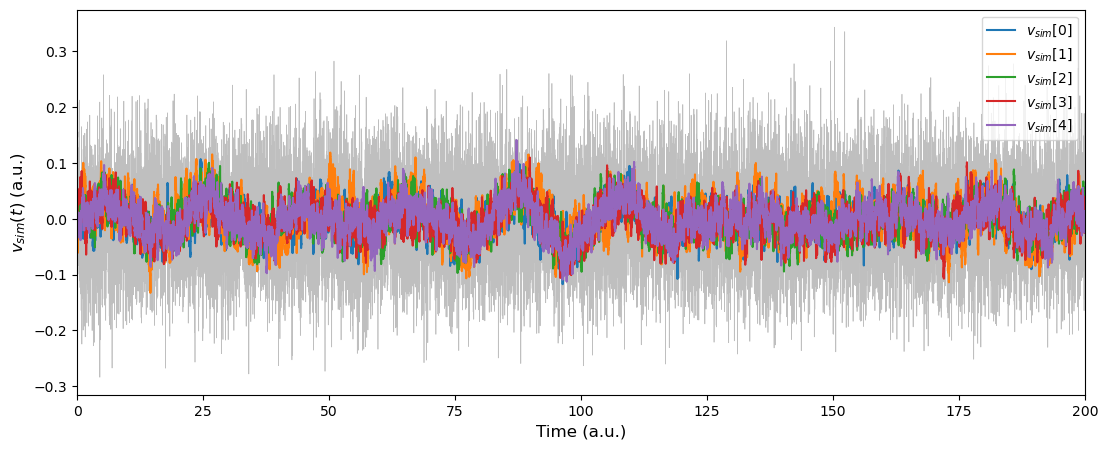

In [75]:
### Check the system and THERMALIZATION (if THERMALIZATION == 1)
t0 = 0
tfinal = 200
dt = 0.01
times = np.arange(t0, tfinal+dt, dt)

v0 = v0std * np.random.standard_normal(Ndim) + v0bias
vsim, noise = Integrate_Langevin_ND_Optimized(Gamma, sigma, initcond=v0, duration=tfinal, integstep=dt)

if THERMALIZATION == 1:
    v0 = vsim[:,-1]
    vsim, noise = Integrate_Langevin_ND_Optimized(Gamma, sigma, initcond=v0, duration=tfinal, integstep=dt)

NPARCELLS_plot = NPARCELLS
if NPARCELLS > 5:
    NPARCELLS_plot = 5

plt.figure(figsize=(13,5))
plt.plot(times, noise[0,:], lw=0.5, color='gray', alpha=0.5)
for i in range(NPARCELLS_plot):
    plt.plot(times, vsim[i,:], label=r'$v_{sim}[%d]$'%i)
plt.xlim(0,tfinal)
plt.ylabel(r'$v_{sim}(t)$ (a.u.)', fontsize=12);
plt.xlabel('Time (a.u.)', fontsize=12);
plt.legend();
plt.show()
    

In [76]:
### Calculation of V_0 = < v_0 v_0^T >
if THERMALIZATION == 1:
    ### Perform explicit THERMALIZATION (it was OK, but no longer needed!)
    # Nsim = 10000
    # THERMALIZATION_time = 100
    # dt = 0.1 * TR / 2
    # V_0 = np.zeros_like(Gamma)
    # for i in range(Nsim):
    #     v0 = v0std*np.random.standard_normal(Ndim) + v0bias
    #     vsim, noise = Integrate_Langevin_ND_Optimized(Gamma, sigma, initcond=v0, duration=THERMALIZATION_time, integstep=dt)
    #     v0 = vsim[:, -1]
    #     V_0 += V_0_calculation_v0fixed(v0)
    # V_0 /= Nsim
    # V_0_sim = V_0
    ### Calculate Vterm with the Lyapunov equation
    D = np.diag(sigma**2 * np.ones(Ndim))
    V_0 = solve_continuous_lyapunov(Gamma, D)
else:
    ndim = np.shape(Gamma)[0]
    V_0 = V_0_calculation_v0gauss(v0std, v0bias, ndim)


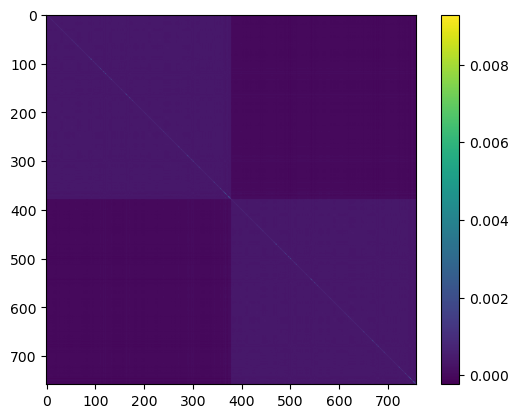

In [77]:
### Plot V_0
plt.imshow(V_0)
plt.colorbar()
plt.show()

---

# Define the timeframe for the calculation



In [78]:
# Define the temporal resolution for the calculations
t0 = 0
tfinal = 200
dt = 1.0

times = np.arange(t0, tfinal+dt, dt)
nsteps = len(times)

---

# Calculation of $V$ (optional, to see the plots of $V(t,s)$ as a function of $t$ or $s$)

In [79]:
### To integrate V we have to calculate the the whole matrices --> it takes too long!
V_CALCULATION = 0

In [80]:
if V_CALCULATION == 1:
    t_times = times[0:nsteps]
    s_times = times[0:nsteps]

    Vts_calc = np.zeros((NPARCELLS,len(t_times),len(s_times)))
    for t in range(len(t_times)):
        for s in range(0,t):
            Vts_calc[:,t,s] = Vts_Langevin_ND(Gamma, sigma, V_0, t_times[t], s_times[s])[0:NPARCELLS] ## I calculate ONLY the x components

In [81]:
# size = nsteps
# LowerDiag = np.tri(size, size)
# for i in range(NPARCELLS):
#     Vts_calc[i,:,:] = np.multiply(Vts_calc[i,:,:], LowerDiag)

In [82]:
if V_CALCULATION == 1:
    plot_matrices(Vts_calc,max_columns=2,title='V(t,s)')

---

### Plot the rows of V

In [83]:
if V_CALCULATION == 1:
    for tn in [50, 100, -1]:
        for dim in range(0,1):#NPARCELLS):
            plt.plot(times, Vts_calc[dim,tn,:], label=f't=%.3f'%times[tn])
    plt.title(f'FDT: V(t,s=0) (rows of the matrices)')
    plt.xlabel('Time [s]')
    plt.ylabel('FDT: V(t,s=0)')
    plt.legend()
    plt.show()

### Integration of $V(t,s)$ over s:
$$ V_s(t) = \int_{0}^{t} V(t,s) ds $$

Obs.: this should be $V_s(t) = I(t,0)$

In [84]:
if V_CALCULATION == 1:
    # Integrate V(t,s) over s
    V_ints = np.zeros((NPARCELLS,nsteps))
    for t_int in range(0,nsteps):
        t = times[t_int]
        V_ints[:,t_int] = numerical_integration_of_Vts_in_s(t, Gamma, V_0, sigma)[0:NPARCELLS]
    for par in range(NPARCELLS):
        plt.plot(times, V_ints[par,:])
    plt.title(r'FDT: $V_s(t)=\int_0^{t} V(t,s)ds$')
    plt.xlabel('Time [t]')
    plt.ylabel('V-FDT')
    plt.show()


Now integration of $V_s(t)$ over $t$

In [85]:
if V_CALCULATION == 1:
    # Integrate Vs(t) over t
    x = times[0:nsteps]
    V_ints_intt = np.zeros(NPARCELLS)
    for par in range(NPARCELLS):
        y = V_ints[par,:]
        V_ints_intt[par] = integrate.trapezoid(y, x=x)

    # Plot Vts for each node
    plt.plot(np.arange(NPARCELLS)+1,V_ints_intt,'.-',color='gray',alpha=0.7)
    plt.gca().set_prop_cycle(None)
    for par in range(NPARCELLS):
        plt.plot(par+1,V_ints_intt[par],'o')
    x_ticks = 10 if NPARCELLS > 20 else 1
    plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))
    plt.title(r'FDT: $V_{ts}=\int_0^{tmax} V_s(t)dt$')
    plt.xlabel('Node')
    plt.ylabel(r'FDT: $V_{st}$')
    plt.show()


The integration of $V(t,s)$ over $s$ and $t$ increases with increasing $t_{max}$. So **it is NOT a good metric**\
Instead, I plot $V_s(t=t_{max})=I(t_{max},0)$ for each node, i.e. integration of the last row:

In [86]:
if V_CALCULATION == 1:
    plt.plot(np.arange(NPARCELLS)+1,V_ints[:,-1],'.-',color='gray',alpha=0.7)
    plt.gca().set_prop_cycle(None)
    for par in range(NPARCELLS):
        plt.plot(par+1,V_ints[par,-1],'o')

    plt.title(r'FDT: $V_s(t_{max})=\int_0^{tmax} V(t_{max},s)ds$')
    plt.xlabel('Node')
    plt.ylabel(r'FDT: $V_s(t_{max})$')
    x_ticks = 10 if NPARCELLS > 20 else 1
    plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))
    plt.show()

---

# Calculation of $I$

**OBS:** as it happens also with $V(t,s)$, integrating $I(t,s)$ over $t$ and $s$ is not a good choice because it gets larger as the observation time increases.\
Therefore a **good metric** for $I$ would be $I(t_{max},0)$.

In [87]:
I_CALCULATION = 1

(758, 758)
(758,)
(758, 758)


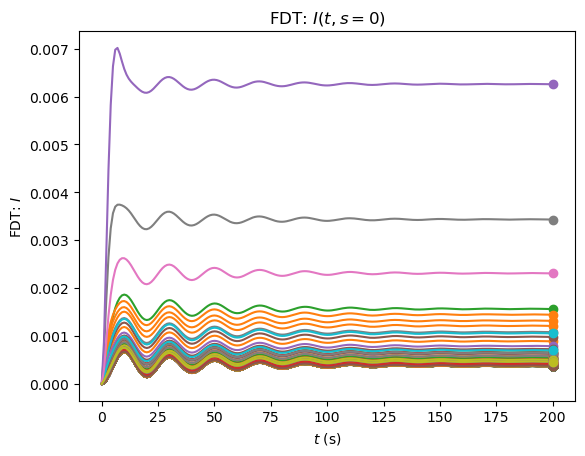

In [88]:
if I_CALCULATION == 1:
    t_times = times[0:nsteps]
    s_times = times[0:nsteps]

    Its_calc = np.zeros((NPARCELLS,len(t_times)))
    print(Gamma.shape)
    print(sigma.shape)
    print(V_0.shape)
    for t in range(len(t_times)):
        Its_calc[:,t] = Its_Langevin_ND(Gamma, sigma, V_0, t_times[t], s_times[0])[0:NPARCELLS] # I keep ONLY for the x-components

    for par in range(NPARCELLS):
        plt.plot(times, Its_calc[par,:])
    plt.gca().set_prop_cycle(None)
    for par in range(NPARCELLS):
        plt.plot(times[-1],Its_calc[par,-1],'o')

    plt.title(r'FDT: $I(t,s=0)$')
    plt.xlabel(r'$t$ (s)')
    plt.ylabel(r'FDT: $I$')
    plt.show()
    plt.show()

Calculation and plot of $I(t_{max}=200,s=0)$ for each node

In [89]:
tmax = 100
ts = 0
I_tmax_s0 = Its_Langevin_ND(Gamma, sigma, V_0, tmax, ts)[0:NPARCELLS]

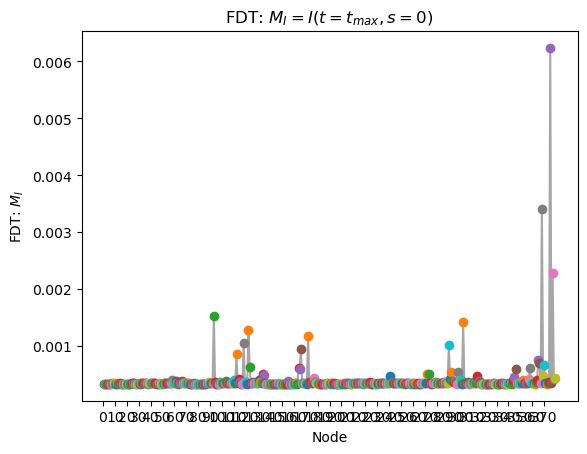

In [90]:
plt.plot(np.arange(NPARCELLS)+1, I_tmax_s0,'.-',color='gray',alpha=0.7)
plt.gca().set_prop_cycle(None)
for par in range(NPARCELLS):
    plt.plot(par+1,I_tmax_s0[par],'o-')

plt.title(r'FDT: $M_I=I(t=t_{max},s=0)$')
plt.xlabel('Node')
plt.ylabel(r'FDT: $M_I$')
x_ticks = 10 if NPARCELLS > 20 else 1
plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))
plt.show()


---

### Comparisson between $V$ and $I$

In [91]:
V_I_COMPARISSON = 0

In [92]:
if V_I_COMPARISSON == 1:
    intV_s0_tmax = numerical_integration_of_Vts_in_s(tmax, Gamma, V_0, sigma)[0:NPARCELLS]
    I_numerical = compute_I_as_numerical_integration_of_V(tmax, 0, Gamma, V_0, sigma)[0:NPARCELLS]

    plt.plot(np.arange(NPARCELLS)+1,intV_s0_tmax,'o-')
    plt.plot(np.arange(NPARCELLS)+1,I_tmax_s0,'*-')
    plt.plot(np.arange(NPARCELLS)+1,I_numerical,'.--')

    plt.title(r'FDT: $M_I=I(t_{max},s=0)$')
    plt.xlabel('Node')
    plt.ylabel(r'FDT: $M_I$')
    x_ticks = 10 if NPARCELLS > 20 else 1
    plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))
    plt.show()

    ###

    from scipy.stats import linregress

    x = intV_s0_tmax
    y = I_tmax_s0
    slope, intercept, r, p, se = linregress(x, y)

    plt.plot(x, y , 'o')
    plt.plot(np.sort(x), slope * np.sort(x) + intercept, '--', color='gray', alpha=0.7, label=r'$R=r^2$=%f'%r**2)
    plt.xlabel('Vs(tmax)')
    plt.ylabel('I(tmax.s=0)')
    plt.legend()
    plt.show()

    ###

    from scipy.stats import pearsonr
    from scipy.stats import spearmanr
    from scipy.stats import kendalltau

    ### FDT Mi vs LZC Deep-sleep
    distribution1 = V_ints_intt
    distribution2 = I_tmax_s0
    # Pearson Correlation Coefficient 
    r, p_value = pearsonr(distribution1, distribution2)
    print('FDT Mi vs LZC N3, Pearson r :',r)
    # Spearman\'s Rank Correlation
    rho, p_value = spearmanr(distribution1, distribution2)
    print('FDT Mi vs LZC N3, Spearman\'s Rank rho :',rho)
    # Kendall\'s Tau
    tau, p_value = kendalltau(distribution1, distribution2)
    print('FDT Mi vs LZC N3, Kendall\'s Tau :',tau)

---

### Plot boxplots

In [93]:

if COND == 1:
    I_W = I_tmax_s0
if COND == 2:
    I_N3 = I_tmax_s0
if COND == 3:
    I_HC = I_tmax_s0
if COND == 4:
    I_MCI = I_tmax_s0
if COND == 5:
    I_AD = I_tmax_s0

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 77.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 80.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 73.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3544: UserWarning: 83.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/cat

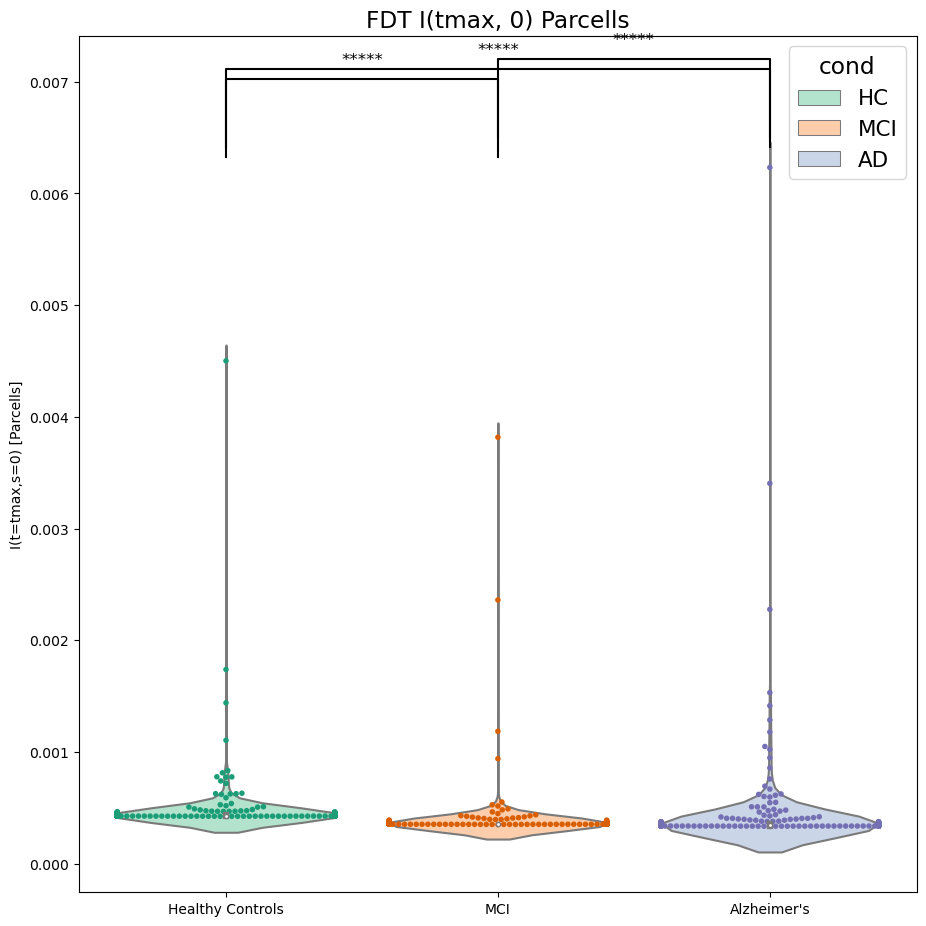

Mean HC  = 0.0004637807524360072
Mean MCI = 0.0003813960978382636
Mean AD = 0.0004056061189854289


In [94]:
if 'I_HC' in locals() and 'I_MCI' in locals() and 'I_AD' in locals():
    datasets = [I_HC, I_MCI, I_AD]
    labels = ['HC', 'MCI', 'AD']

    if SAMESIGMA == 1:
        filename = f"Dataset_W-N3_fig_MI_I(tmx,s=0)_SAMESIGMA_{SAMESIGMA}"
    else:
        filename = f"Dataset_W-N3_fig_MI_I(tmx,s=0)_SAMESIGMA_{SAMESIGMA}_HETERO_{HETEROGENEOUS}"

    data = pd.DataFrame({
        "value": np.concatenate([I_HC, I_MCI, I_AD]),
        "cond": ["HC"] * len(I_HC) + ["MCI"] * len(I_MCI) + ["AD"] * len(I_AD),
    })
    filename = f"FDT_I_Violinplot_par_COND_{COND}"

    fig, ax = plt.subplots(figsize=(10, 10))
    #fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

    plot_violins_HC_MCI_AD(ax=ax, data=data,
            font_scale=1.4, 
            metric='I(t=tmax,s=0) [Parcells]',
            point_size = 4,
            xgrid=False,
            plot_title='FDT I(tmax, 0) Parcells',
            saveplot = 1,
            filename=filename,
            dpi=300)
    
    print('Mean HC  =',np.mean(I_HC))
    print('Mean MCI =',np.mean(I_MCI))
    print('Mean AD =',np.mean(I_AD))

elif 'I_W' in locals() and 'I_N3' in locals():
    datasets = [I_W, I_N3]
    labels = ['W', 'N3']

    if SAMESIGMA == 1:
        filename = f"Dataset_W-N3_fig_MI_I(tmx,s=0)_SAMESIGMA_{SAMESIGMA}"
    else:
        filename = f"Dataset_W-N3_fig_MI_I(tmx,s=0)_SAMESIGMA_{SAMESIGMA}_HETERO_{HETEROGENEOUS}"

    data = pd.DataFrame({
        "value": np.concatenate([I_W, I_N3]),
        "cond": ["W"] * len(I_W) + ["N3"] * len(I_N3),
    })



    filename = f"FDT_I_Violinplot_par_COND_{COND}"

    fig, ax = plt.subplots(figsize=(5, 5))
    plot_violins_W_N3(ax=ax, data=data,
            font_scale=1.4, 
            metric='I(t=tmax,s=0) [Parcells]',
            point_size = 4,
            xgrid=False,
            plot_title='FDT I(tmax, 0) Parcells',
            saveplot = 1,
            filename=filename,
            dpi=300)
    
    print('Mean W  =',np.mean(I_W))
    print('Mean N3 =',np.mean(I_N3))


Averages and Std Dev:
HC: avg=0.0004637807524360072, stdev=0.0002325593300542387, len=379
MCI: avg=0.0003813960978382636, stdev=0.00021178694883760307, len=379
AD: avg=0.0004056061189854289, stdev=0.00037461403780904095, len=379

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC vs. MCI: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.186e-110 U_stat=1.391e+05
MCI vs. AD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.091e-44 U_stat=1.141e+05
HC vs. AD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.045e-90 U_stat=1.324e+05


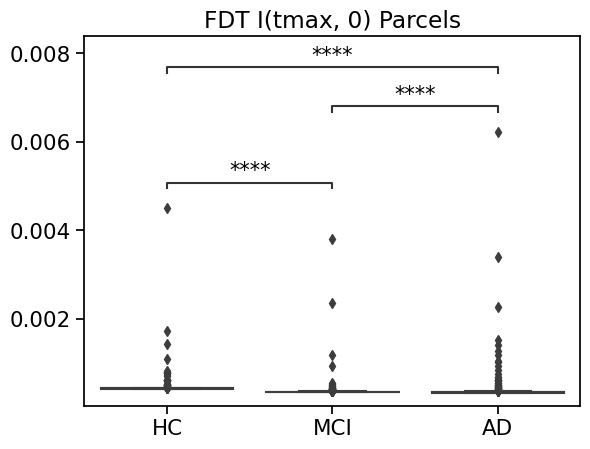

done!


In [95]:
import p_values as p_values  # Make sure this is working!

if 'I_HC' in locals() and 'I_MCI' in locals() and 'I_AD' in locals():
    datasets = [I_HC, I_MCI, I_AD]
    labels = ['HC', 'MCI', 'AD']

data = pd.DataFrame({
        "value": np.concatenate([I_HC, I_MCI, I_AD]),
        "cond": ["HC"] * len(I_HC) + ["MCI"] * len(I_MCI) + ["AD"] * len(I_AD),
    })
# Assume these are defined:
# I_FDT_sub, cond_index_map, group_sizes


# Create dictionary like in loadResultsCohort demo
resI = {
    'HC': I_HC,
    'MCI': I_MCI,
    'AD': I_AD
}

# Plot
plt.rcParams.update({'font.size': 15})
p_values.plotComparisonAcrossLabels2(
    resI,
    columnLables=['HC', 'MCI', 'AD'],
    graphLabel='FDT I(tmax, 0) Parcels'
)

print("done!")


---

# To-do 1
- Adapt the code to:
    - only calculate analytically. **DONE**
    - the use of empiric connectivities and frequencies. **DONE**
    - integrate |V(t,0)| and |I(t,0)| from t=0 to t=tfinal **DONE**
    - Change v0 to be the set after some simulated THERMALIZATION. **DONE**

# To-do 2
- Adapt the code to:
    - Calculate for all subjects in different conditions with out having to run it twice to make the boxplots :(